In [1]:
import Interpolations, Plots, Random, Ipopt, Statistics, GLPK
using ColorTypes, StatsBase
using NumericalIntegration, JuMP, GLPK, Plots, Random, Interpolations, Statistics, LinearAlgebra, Distributions

In [2]:
global const ŒîT            = 1e-4 # units: seconds\n",
global const GaussPerTesla = 10000.0;
global const FOV           = 10.0                             # units: centimeters\n",
global const ŒîK            = 1/FOV                            # units: radians / centimeters\n",
global const Œ≥             = 4258.0                           # units: Hz / Gauss\n",
global const Œ±             = 1 / (Œ≥ * FOV)
global const c             = 334/1e6                          # units: seconds\n",
global const rng           = Random.MersenneTwister(1)
global const G_max         = 5.0                              # units: Gauss/cm, equivalent to 50mT/m\n",
global const S_max         = 20000.0                          # units: Gauss/cm/s, equivalent to 200T/m/s\n",
global const S_min         = 7027.0                           # units: Gauss/millimeters/seconds\n",
global const PNS_max       = 80.0                             # percent of peripheral nerve stimulation"

80.0

In [3]:
# generate candidate paths
# start with uniform grid
function find_path_tsp(xs)
    E   = selected_edges(xs, size(xs, 1))
    # find path\n",
    ES  = similar(E)
    idx = 1
    e_0 = E[1][2]
    i_0 = 1
    e_0 = E[i_0][2]
    ES[1] = E[i_0]
    while idx < length(E) - 1
        cnds  = findall([e_0 ‚àà e for e ‚àà E])
        tmp_c = E[cnds]
        tmp_e = reduce(vcat,[collect(e) for e ‚àà ES[1:idx]])
        tmp_i = any(reshape([ i ‚àâ tmp_e for j ‚àà tmp_c for i ‚àà j],2,2)',dims=2)[:]
        nxt_e = tmp_c[tmp_i][1]
        idx   = idx + 1
        nxt_e = collect(nxt_e)
        tmp_e = (nxt_e[nxt_e .== e_0][1], nxt_e[nxt_e .!== e_0][1])
        ES[idx] = tmp_e
        e_0   = [e for e ‚àà nxt_e if e != e_0][1]

    end
    # last one\n",
    nxt_e = ES[end-1]
    e_0   = nxt_e[2]
    cnds  = findall([e_0 ‚àà e for e ‚àà E])
    tmp_c = E[cnds]
    ES[end] = [e for e ‚àà tmp_c if e != nxt_e][1]
    ES[end] = (ES[end-1][2],ES[1][1])
    return ES
end

function generate_distance_matrix(n , Œî)
    Z = [ [n1+Œî,n2+Œî] for n1 = 1:n, n2 = 1:n]
    Z = reduce(hcat,Z)
    ‚Ñì = size(Z,2)
    X = Z[1,:] .+ rand.(Uniform(-0.5,0.5),‚Ñì,1)[:]
    Y = Z[2,:] .+ rand.(Uniform(-0.5,0.5),‚Ñì,1)[:]
    Œ¥y= mean(Y)
    Œ¥x= mean(X)
    X = X .- Œ¥x
    Y = Y .- Œ¥y
    X = round.(X,digits=1)
    Y = round.(Y,digits=1)
    D = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:‚Ñì, j in 1:‚Ñì]
    return X[:], Y[:], D[:,:]
end
function selected_edges(x::Matrix{Float64}, n)
    n = size(x,1)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.0]
end
function find_path(xs)
    E   = selected_edges(xs, size(xs, 1))
    # find path
    ES  = similar(E)
    idx = 1
    e_0 = E[1][2]
    i_0 = 1
    e_0 = E[i_0][2]
    ES[1] = E[i_0]
    while idx < length(E) 
        cnds  = findall([e_0 ‚àà e for e ‚àà E])
        tmp_c = E[cnds]
        tmp_e = reduce(vcat,[collect(e) for e ‚àà ES[1:idx]])
        tmp_m = [ i ‚àâ tmp_e for j ‚àà tmp_c for i ‚àà j];
        num_m = Int64(floor(length(tmp_m)/2));
        tmp_i = any(reshape(tmp_m,2,num_m)',dims=2)[:]
        #tmp_i = any(reshape(tmp_m,2,2)',dims=2)[:]
        if !any(tmp_i) #path to nowhere, delete nodes
            deleteat!(E,idx)
            deleteat!(E,idx)
            deleteat!(ES,idx)
            deleteat!(ES,idx)
            e_0 = E[1][2]
            ES[1]= E[1]
        else
            nxt_e = tmp_c[tmp_i][1]
            #idx   = idx + 1
            nxt_e = collect(nxt_e)
            tmp_e = (nxt_e[nxt_e .== e_0][1], nxt_e[nxt_e .!== e_0][1])
            ES[idx] = tmp_e
            e_0   = [e for e ‚àà nxt_e if e != e_0][1]
        end
        idx = idx + 1
    end
    # last one
    nxt_e = ES[end-1]
    e_0   = nxt_e[2]
    cnds  = findall([e_0 ‚àà e for e ‚àà E])
    tmp_c = E[cnds]
    lst_e = [e for e ‚àà tmp_c if e != nxt_e]
    if !isempty(lst_e) #path to nowhere
        ES[end] = [e for e ‚àà tmp_c if e != nxt_e][1]
    else
        pop!(ES)
        pop!(ES)
    end
    gn   = findall([e[1] > n .|| e[2] > n for e in ES])
    deleteat!(ES,gn[:])
    return ES
end
function get_kspace_trajectory_path(xs,ux,uy,d)
    
    ES   = find_path_tsp(xs)
    n    = length(ES)
    D    = sum(d .* xs)         # D mm
    NK   = Int64(round(D/ŒîK))   # number of samples to have spatial resolution equal to ŒîK
    #Tint = cumsum(ones(NK)).*ŒîT # traversed time in seconds
    Tint = LinRange(ŒîT, ŒîT*NK, n)
    Xn   = ux[:]
    Yn   = uy[:]
    Kx   = [Xn[e[1]] for e ‚àà ES]
    Ky   = [Yn[e[1]] for e ‚àà ES]
    NQ   = length(Kx);          # number of nodes visited in graph
    #Tund = LinRange(Tint[1],Tint[end],NQ)
    #Kxs  = CubicSplineInterpolation(Tund,Kx,extrapolation_bc = Line())
    #Kys  = CubicSplineInterpolation(Tund,Ky,extrapolation_bc = Line())
    return Kx, Ky, Tint
end

function get_kspace_trajectory_shortest_path(xs,ux,uy,d)
    
    ES   = find_path(xs)
    n    = length(ES)
    D    = sum(d .* xs)         # D mm
    NK   = Int64(round(D/ŒîK))   # number of samples to have spatial resolution equal to ŒîK
    #Tint = cumsum(ones(NK)).*ŒîT # traversed time in seconds
    Tint = LinRange(ŒîT, ŒîT*NK, n)
    Xn   = ux[:]
    Yn   = uy[:]
    Kx   = [Xn[e[1]] for e ‚àà ES]
    Ky   = [Yn[e[1]] for e ‚àà ES]
    NQ   = length(Kx);          # number of nodes visited in graph
    #Tund = LinRange(Tint[1],Tint[end],NQ)
    #Kxs  = CubicSplineInterpolation(Tund,Kx,extrapolation_bc = Line())
    #Kys  = CubicSplineInterpolation(Tund,Ky,extrapolation_bc = Line())
    return Kx, Ky, Tint
end
function get_grad_pns_shortest_path(xs,ux,uy,d)

    Kxs,Kys,T     = get_kspace_trajectory_shortest_path(xs,ux,uy,d)

    Gx = Œ±.* diff(Kxs)/ŒîT;
    Gy = Œ±.* diff(Kys)/ŒîT

    Gx = [0.0 ; Gx[:]] # zero pad
    Gy = [0.0 ; Gy[:]]

    Sx = diff(Gx)/ŒîT
    Sy = diff(Gy)/ŒîT

    Sx = [0.0 ; Sx[:]]
    Sy = [0.0 ; Sy[:]]

    fxt = (c .* Sx *ŒîT) ./ (c .+ T[end]*ŒîT .- T*ŒîT) .^2
    fyt = (c .* Sy *ŒîT) ./ (c .+ T[end]*ŒîT .- T*ŒîT) .^2

    Rxt = cumsum(fxt[:]) .* 1/S_min
    Ryt = cumsum(fyt[:]) .* 1/S_min

    PNS = sqrt.(Rxt.^2 .+ Ryt.^2) .*100

    G   = sqrt.(Gx.^2 .+ Gy.^2)
    S   = sqrt.(Sx.^2 .+ Sy.^2 )
    return PNS[:], G[:], S[:], T[:]
end

function get_grad_pns_path(xs,ux,uy,d)

    Kxs,Kys,T     = get_kspace_trajectory_path(xs,ux,uy,d)

    Gx = Œ±.* diff(Kxs)/ŒîT;
    Gy = Œ±.* diff(Kys)/ŒîT

    Gx = [0.0 ; Gx[:]] # zero pad
    Gy = [0.0 ; Gy[:]]

    Sx = diff(Gx)/ŒîT
    Sy = diff(Gy)/ŒîT

    Sx = [0.0 ; Sx[:]]
    Sy = [0.0 ; Sy[:]]

    fxt = (c .* Sx *ŒîT) ./ (c .+ T[end]*ŒîT .- T*ŒîT) .^2
    fyt = (c .* Sy *ŒîT) ./ (c .+ T[end]*ŒîT .- T*ŒîT) .^2

    Rxt = cumsum(fxt[:]) .* 1/S_min
    Ryt = cumsum(fyt[:]) .* 1/S_min

    PNS = sqrt.(Rxt.^2 .+ Ryt.^2) .*100

    G   = sqrt.(Gx.^2 .+ Gy.^2)
    S   = sqrt.(Sx.^2 .+ Sy.^2 )
    return PNS[:], G[:], S[:], T[:]
end
function build_tsp_model(d, n)
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x) )
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)
    return model
end
function make_triangular(A)
    n = size(A,1)
    for i in 1:n
        for j in i:n
            A[i,j] = 0.0
        end
    end
    return A
end
# helper function for finding dubtours
function subtour(edges::Vector{Tuple{Int,Int}}, n)
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors =
                [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end

subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

function get_tsp_path(d,n)

    # find a good start path
    iterative_model = build_tsp_model(d, n);
    optimize!(iterative_model);
    global time_iterated = solve_time(iterative_model)
    global cycle = subtour(iterative_model[:x])
    while 1 < length(cycle) < n
        #println(\Found cycle of length $(length(cycle))\)
        S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
        @constraint(
            iterative_model,
            sum(iterative_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1,
        )
        optimize!(iterative_model)
        global time_iterated += solve_time(iterative_model)
        global cycle = subtour(iterative_model[:x])
    end

    objective_value(iterative_model)
    A=value.(iterative_model[:x])
    A=make_triangular(A)
    return A
end

function compare_tuples(t1,t2)
    c1 = (t1[1] == t2[1]) || (t1[1] == t2[2])
    c2 = (t1[2] == t2[1]) || (t1[2] == t2[1])
    return c1 & c2
end

function map_node_matrix(X,Y,An,Xn,Yn)
    P = find_path_tsp(An)
    ‚Ñì = length(X)
    A = zeros(‚Ñì,‚Ñì);
    for p ‚àà P
        x1 = Xn[p[1]]
        y1 = Yn[p[1]]
        y2 = Yn[p[2]]
        x2 = Xn[p[2]]
        i1 = findall((X .== x1) .&& (Y .== y1))[1]
        j1 = findall((X .== x2) .&& (Y .== y2))[1]
        A[i1,j1] = 1.0
        A[j1,i1] = 1.0
    end

    return make_triangular(A)
end
            
function map_pns_matrix(X,Y,An,Xn,Yn,PNS)
    P = find_path(An)
    ‚Ñì = length(X)
    A = zeros(‚Ñì,‚Ñì);
    idx= 1
    for p ‚àà P
        x1 = Xn[p[1]]
        y1 = Yn[p[1]]
        y2 = Yn[p[2]]
        x2 = Xn[p[2]]
        i1 = findall((X .== x1) .&& (Y .== y1))[1]
        j1 = findall((X .== x2) .&& (Y .== y2))[1]
        A[i1,j1] = PNS[idx]
        A[j1,i1] = PNS[idx]
        idx = idx + 1;
    end

    return A
end

map_pns_matrix (generic function with 1 method)

In [4]:
function get_kspace_trajectory_mat(d,xs,X,Y,idx1,idx2)
    Kx   = [X[idx1],X[idx2]]
    Ky   = [Y[idx1],Y[idx2]]
    NQ   = 10
    t1   = 0.00
    t2   = d[idx1,idx2]*ŒîT
    if t2 < t1
        t1 = t2
        t2 = ŒîT
    end
    if t2 == t1
        t2 = t2+ŒîT
    end
    T    = LinRange(t1,t2,2)
    Kxs  = CubicSplineInterpolation(T,Kx,extrapolation_bc = Line())
    Kys  = CubicSplineInterpolation(T,Ky,extrapolation_bc = Line())
    return Kxs, Kys, T
end

get_kspace_trajectory_mat (generic function with 1 method)

In [5]:
function get_slew_rate_mat(d,A,X,Y)
    n = size(A,1)
    SMATX = zeros(n,n)
    SMATY = zeros(n,n)
    for i = 1:n
        for j = (i+1):n
            kxs,kys,tund=get_kspace_trajectory_mat(d,A,X,Y,i,j)
            T = LinRange(tund[1],tund[2],100)
            kx= kxs(T)
            ky= kys(T)
            Gx = Œ±.* diff(kx)/ŒîT;
            Gy = Œ±.* diff(Ky)/ŒîT

            Gx = [0.0 ; Gx[:]] # zero pad
            Gy = [0.0 ; Gy[:]]

            Sx = diff(Gx)/ŒîT
            Sy = diff(Gy)/ŒîT
            Sx
            SMATX[i,j]=mean(Sx)
            SMATY[i,j]=mean(Sy)
        end
    end
    SMATX=SMATX+SMATX' 
    SMATY=SMATY+SMATY'
    return SMATX,SMATY
end

get_slew_rate_mat (generic function with 1 method)

In [6]:
q = 10
n = q^2
m = 50
Œî = 5.0 #nodes are 5cm apart
X,Y,d = generate_distance_matrix(q,Œî)
A      = get_tsp_path(d,n)
PNS,G,S = get_grad_pns_path(A,X,Y,d)
#Kx,Ky,T=get_kspace_trajectory_path(make_triangular(A),X ,Y,d)
K = 200; # paths to generate
ùêÄ = Array{Any}(nothing, K+1) 
ùêó = Array{Any}(nothing, K+1)
ùêò = Array{Any}(nothing, K+1)
ùêÜ = Array{Any}(nothing, K+1)
ùêí = Array{Any}(nothing, K+1)
ùêè = Array{Any}(nothing, K+1)
ùêÉ = Array{Any}(nothing, K+1)
idx = 1
while idx < K+1
    idxs   = sample(1:n,m,replace=false)
    Xn    = X[idxs]
    Yn    = Y[idxs]
    dn    = [sqrt((Xn[i] - Xn[j])^2 + (Yn[i] - Yn[j])^2) for i in 1:m, j in 1:m]

    n_unique = size(unique([Xn Yn],dims=1),1)
    while (n_unique < m) 
        idxs   = sample(1:n,m,replace=false)
        Xn    = deepcopy(X[idxs])
        Yn    = deepcopy(Y[idxs])
        dn    = [sqrt((Xn[i] - Xn[j])^2 + (Yn[i] - Yn[j])^2) for i in 1:m, j in 1:m]
        n_unique = unique([Xn Yn],dims=1)
    end
    An    = deepcopy(get_tsp_path(dn,m))
    An    = deepcopy(make_triangular(An))
    PNSn,Gn,Sn = get_grad_pns_path(An,Xn,Yn,dn)
    cnd    = all((PNSn .<= PNS_max) .&& (Gn .<= G_max) .&& (Sn .<= S_max)) .&& (sum(An) .== m)

    if cnd
        ùêÉ[idx] = dn
        ùêè[idx] = PNSn
        ùêÜ[idx] = Gn
        ùêí[idx] = Sn
        ùêÄ[idx] = An
        ùêó[idx] = Xn
        ùêò[idx] = Yn
        idx = idx + 1
    end
    
end
ùêÉ[K+1] = d
ùêè[K+1] = PNS
ùêÜ[K+1] = G
ùêí[K+1] = S
ùêÄ[K+1] = A
ùêó[K+1] = X
ùêò[K+1] = Y;


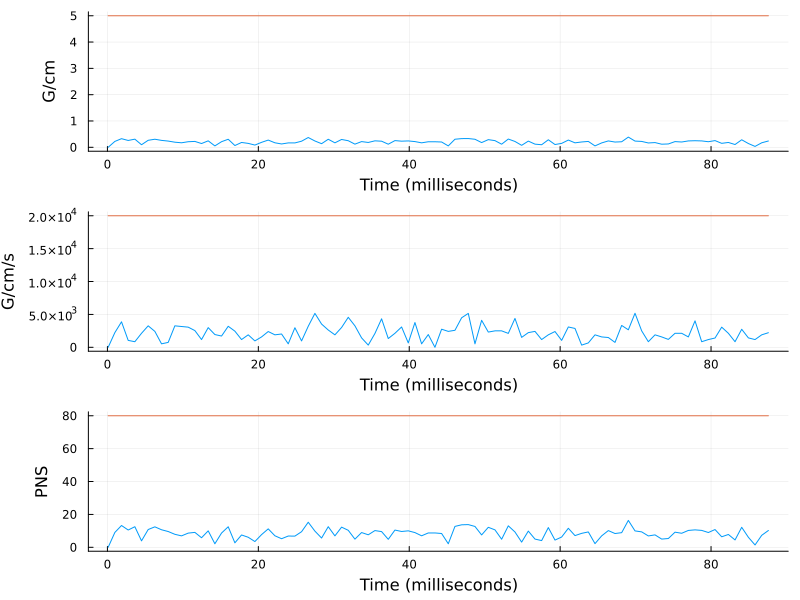

In [7]:
PNS,G,S, T = get_grad_pns_path(A,X,Y,d)
grad_plot = plot(T*1000,G); ylabel!("G/cm"); xlabel!("Time (milliseconds)"); plot!(T*1000,ones(size(G))*G_max)
slew_plot = plot(T*1000,S); ylabel!("G/cm/s"); xlabel!("Time (milliseconds)");plot!(T*1000,ones(size(G))*S_max)
pns_plot  = plot(T*1000,PNS);ylabel!("PNS"); xlabel!("Time (milliseconds)"); plot!(T*1000,ones(size(G))*PNS_max)
plot(T[3:end],PNS)

plot(grad_plot,slew_plot,pns_plot,layout= (3,1),size = (800,600),legend=false)



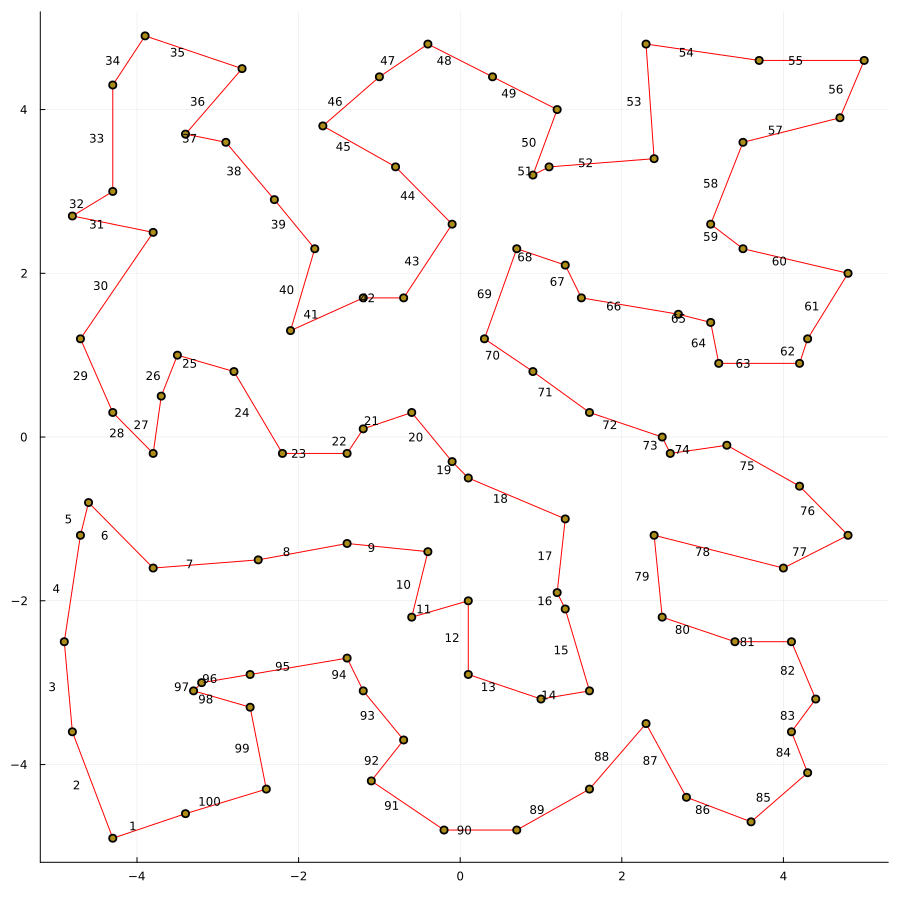

In [8]:
ES = find_path_tsp(A)
# plot edge order: they are not in order
plt = Plots.plot()

idx = 1
for (i, j) in ES

    plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false, color =:red)
    ux = sum([X[i], X[j]])/2 -.2
    uy = sum([Y[i], Y[j]])/2 
    annotate!(ux,uy, text(idx, :black, :center, 8))

    idx = idx + 1
end
plt
scatter!(X,Y); #ylims!(0,5); xlims!(0,5)
plot(plt,size=(900,900))

In [11]:
function generate_columns(Œ†,Œõ,d,ŒîTMS,d_max)
    # dual formulation\n",
    n = size(d,1)
    b = zeros(1,n)
    b[1]   = 1.0
    b[end] = -1.0
    dmodel = Model(GLPK.Optimizer)
    @variable(dmodel, x[1:n,1:n], Bin)
    @objective(dmodel, Min, sum((ŒîTMS*d .- (Œ†.* d*ŒîTMS)).*x) - Œõ)
    @constraint(dmodel, [i = 1:n], x[i,i]== 0);
    @constraint(dmodel, [i = 1:n], sum(x[i, :]) - sum(x[:, i]) == b[i])
    @constraint(dmodel, sum(x) >= d_max)
    optimize!(dmodel);
    PNS,G,S = get_grad_pns_shortest_path(value.(dmodel[:x]),X,Y,d);
    @objective(dmodel, Min, sum((ŒîTMS*d .+ sum(PNS) .- (Œ†.* d*ŒîTMS)).*x) - Œõ)

    display(objective_value(dmodel))
    if objective_value(dmodel) > 1
        return value.(dmodel[:x])
    end
    return nothing
end

generate_columns (generic function with 1 method)

In [12]:
Ts = [ŒîT*sum(ùêÄ[p].*ùêÉ[p]) for p = 1:K].*1000
T_MAX = percentile(Ts,10.5)
D_MAX = sum(A.*d)/3
ŒîTMS  = ŒîT.*1000
N_p   = K+1
M = Model(GLPK.Optimizer)
@variable(M, Œª[1:N_p] >= 0.0)
ùõå = @constraint(M, sum(Œª) == 1.0)
ùõë = @constraint(M, sum(sum(ùêÉ[p].*ùêÄ[p])*Œª[p] for p =1:N_p) >= D_MAX); #subject to path constraints
@objective(M,Min, sum((ŒîTMS*sum(ùêÉ[p].*ùêÄ[p]) + sum(ùêè[p]))*Œª[p] for p=1:N_p) ); #minimize time

while true 
    optimize!(M);
    display(N_p)
    Œ† = dual.(ùõë)
    Œõ = dual.(ùõå)
    idxs=(value.(M[:Œª]).>0) .* LinRange(1,N_p,N_p)
    #display(idxs[idxs .> 0])
    #display([Œ†,Œõ]')
    b_idx = argmax(value.(M[:Œª]))
    d_max = sum(ùêÄ[b_idx])
    new_path = generate_columns(Œ†,Œõ,d,ŒîTMS,d_max);
    # new path found
    # need to compute pns
    if isnothing(new_path)
        break
    else
        PNS,G,S = get_grad_pns_shortest_path(make_triangular(new_path),X,Y,d);
        push!(ùêÉ)
        push!(ùêè, PNS[:])
        push!(ùêÜ,G[:])
        push!(ùêí,S[:])
        push!(ùêÄ, new_path)
        push!(Œª, @variable(M, lower_bound=0.0, upper_bound=1.0,base_name = "Œª[$(N_p+1)]"))
            
    end
    N_p = deepcopy(N_p + 1);  
    ùõë = @constraint(M, sum(sum(ùêÄ[p].*d)*Œª[p] for p =1:N_p) >= 30.0)

end

201

-529.4950298952695

In [13]:
plt = Plots.plot()
for k = 1:K
    Ek = find_path_tsp(ùêÄ[k])
    # plot edge order: they are not in order

    Xn = ùêó[k]
    Yn = ùêò[k]
    idx = 1
    for (i, j) in Ek

        plot!([Xn[i], Xn[j]], [Yn[i], Yn[j]]; legend = false,color = RGB(rand(3)...),linewidth=:1,alpha=:0.5)
        ux = sum([Xn[i], Xn[j]])/2 -.2
        uy = sum([Yn[i], Yn[j]])/2 
        #annotate!(ux,uy, text(idx, :black, :center, 8))
        idx = idx + 1
    end


end
b_idx = argmin(value.(M[:Œª]))
EE = find_path_tsp(make_triangular(ùêÄ[b_idx]))
# plot edge order: they are not in order

Xn = ùêó[b_idx]
Yn = ùêò[b_idx]
idx = 1
for (i, j) in EE

    plot!([Xn[i], Xn[j]], [Yn[i], Yn[j]]; legend = false, color =:red2,linewidth=:8,alpha=:0.5)
    ux = sum([Xn[i], Xn[j]])/2 
    uy = sum([Yn[i], Yn[j]])/2 
    annotate!(ux,uy, text(idx, :black, :center, 14))

     idx = idx + 1
end

scatter!(X,Y,color=:black,markersize=:4); #ylims!(0,5); xlims!(0,5)
plot(plt,size=(900,900));
xlabel!("Kx")
ylabel!("Ky")
title!("K-space paths")
#scatter!([X[1]],[Y[1]],markersize=:10,color=:red)
#scatter!([X[end]],[Y[end]],markersize=:10,color=:blue)